# MLP con Early Stopping y Dropout (Core)
Descripción:

En esta actividad, implementarás una red MLP más avanzada, utilizando técnicas como dropout y early stopping para evitar el sobreajuste. El dataset seleccionado es el “Heart Disease UCI” de Kaggle, donde se intentará predecir si un paciente tiene una enfermedad cardíaca o no basándose en varias características.

Enlace al dataset: https://www.kaggle.com/ronitf/heart-disease-uci (ESTE ENLACE ESTÁ DAÑADO, ASÍ QUE SE DECIDIÓ TRABAJAR CON OTRO DATASET CON NOMBRE SIMILAR)

https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data/data


## Objetivo:

El objetivo de esta actividad es entrenar una red MLP utilizando dropout para regularizar la red y early stopping para detener el entrenamiento cuando el rendimiento en el conjunto de validación deje de mejorar. Al final, se comparará el rendimiento de este modelo con el de un MLP básico.



Column Descriptions:

id (Unique id for each patient)

age (Age of the patient in years)

origin (place of study)

sex (Male/Female)

cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])

trestbps resting blood pressure (resting blood
pressure (in mm Hg on admission to the hospital))

chol (serum cholesterol in mg/dl)

fbs (if fasting blood sugar > 120 mg/dl)

restecg (resting electrocardiographic results)
-- Values: [normal, stt abnormality, lv hypertrophy]

thalach: maximum heart rate achieved

exang: exercise-induced angina (True/ False)

oldpeak: ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

ca: number of major vessels (0-3) colored by fluoroscopy

thal: [normal; fixed defect; reversible defect]

num: the predicted attribute

# 1. Carga de datos:

  – Descarga el dataset “Heart Disease UCI” de Kaggle. Explora las características que están relacionadas con la edad, el sexo, la presión arterial y otras variables clínicas.
  
  – Verifica si hay valores nulos en el dataset y realiza el preprocesamiento necesario, como la imputación de valores faltantes y la normalización de las variables numéricas.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/9_Core_heart_disease_uci.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [21]:
# Verificando si hay datos nulos (%)
print("Valores nulos:")
print((df.isnull().sum() * 100 / len(df)).round(2))
print("\n")

# Verificando si hay duplicados
print("Valores duplicados:")
print(df.duplicated().sum())
print("\n")

Valores nulos:
id           0.00
age          0.00
sex          0.00
dataset      0.00
cp           0.00
trestbps     6.41
chol         3.26
fbs          9.78
restecg      0.22
thalch       5.98
exang        5.98
oldpeak      6.74
slope       33.59
ca          66.41
thal        52.83
num          0.00
dtype: float64


Valores duplicados:
0




In [22]:
# Detectar outliers en variables numéricas
def outliers_IQR(df):
    # Filtrar solo columnas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)  # Primer cuartil
        Q3 = df[col].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1               # Rango intercuartílico

        # Definir los límites inferior y superior de los valores atípicos
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\n🚩 Outliers detected in {col}: {outliers.shape[0]}")

        # Opcional: Remover outliers
        # df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Llamar a la función
outliers_IQR(df)


🚩 Outliers detected in id: 0

🚩 Outliers detected in age: 0

🚩 Outliers detected in trestbps: 28

🚩 Outliers detected in chol: 183

🚩 Outliers detected in thalch: 2

🚩 Outliers detected in oldpeak: 16

🚩 Outliers detected in ca: 20

🚩 Outliers detected in num: 0


In [23]:
df.describe(include='object').round()

,sex,dataset,cp,fbs,restecg,exang,slope,thal
count,920,920,920,830,918,865,611,434
unique,2,4,4,2,3,2,3,3
top,Male,Cleveland,asymptomatic,False,normal,False,flat,normal
freq,726,304,496,692,551,528,345,196


In [24]:
print(df.describe().round())

          id    age  trestbps   chol  thalch  oldpeak     ca    num
count  920.0  920.0     861.0  890.0   865.0    858.0  309.0  920.0
mean   460.0   54.0     132.0  199.0   138.0      1.0    1.0    1.0
std    266.0    9.0      19.0  111.0    26.0      1.0    1.0    1.0
min      1.0   28.0       0.0    0.0    60.0     -3.0    0.0    0.0
25%    231.0   47.0     120.0  175.0   120.0      0.0    0.0    0.0
50%    460.0   54.0     130.0  223.0   140.0      0.0    0.0    1.0
75%    690.0   60.0     140.0  268.0   157.0      2.0    1.0    2.0
max    920.0   77.0     200.0  603.0   202.0      6.0    3.0    4.0


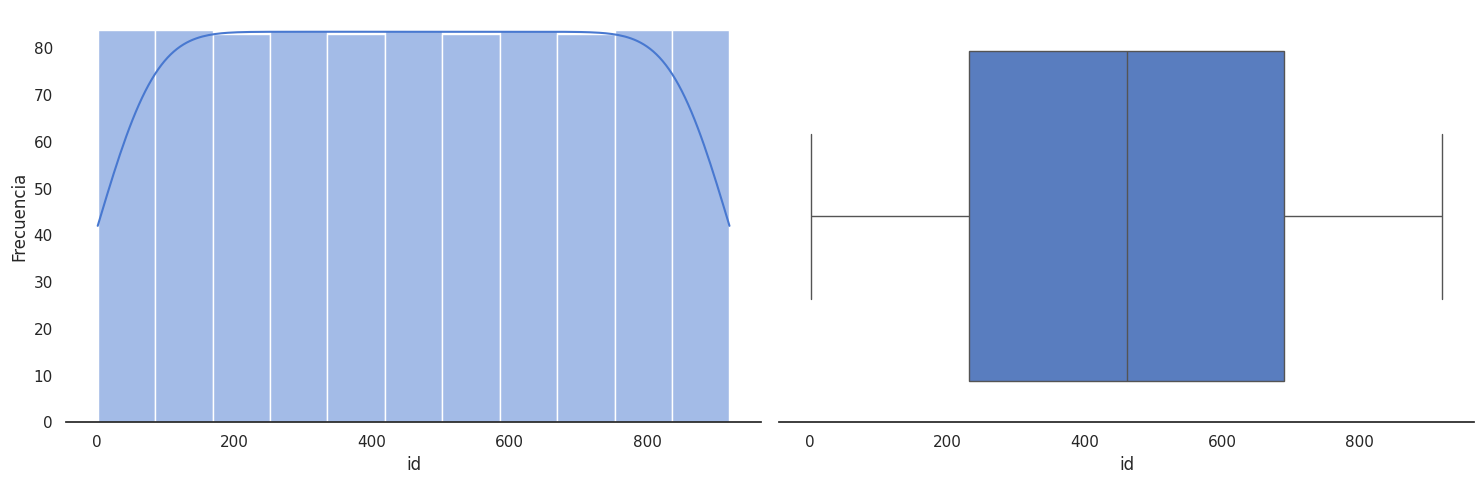

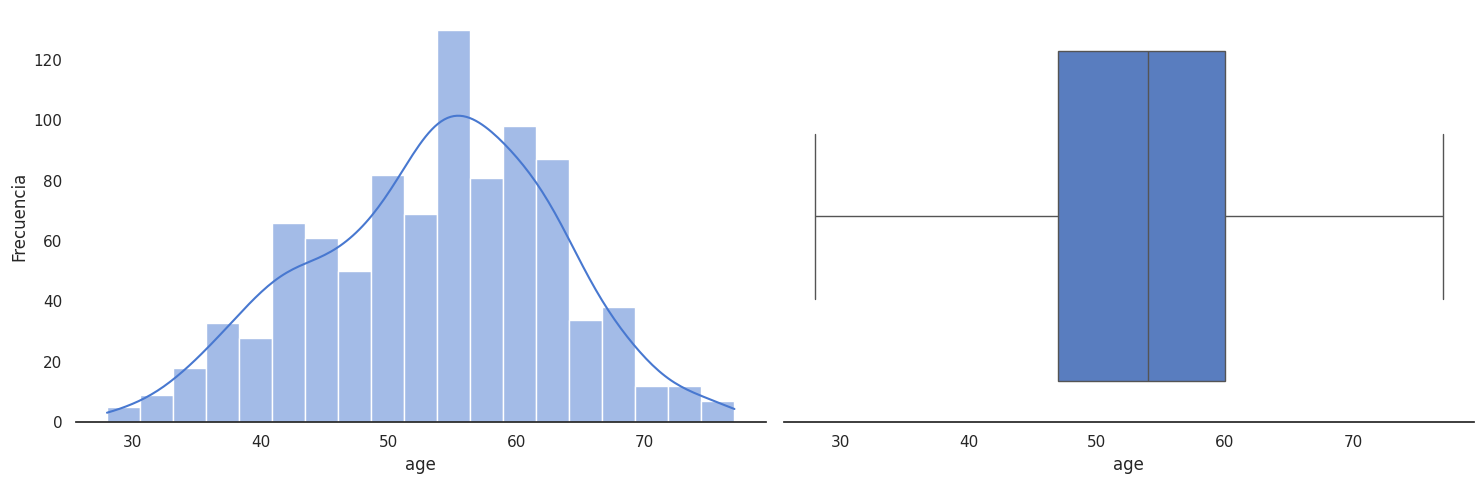

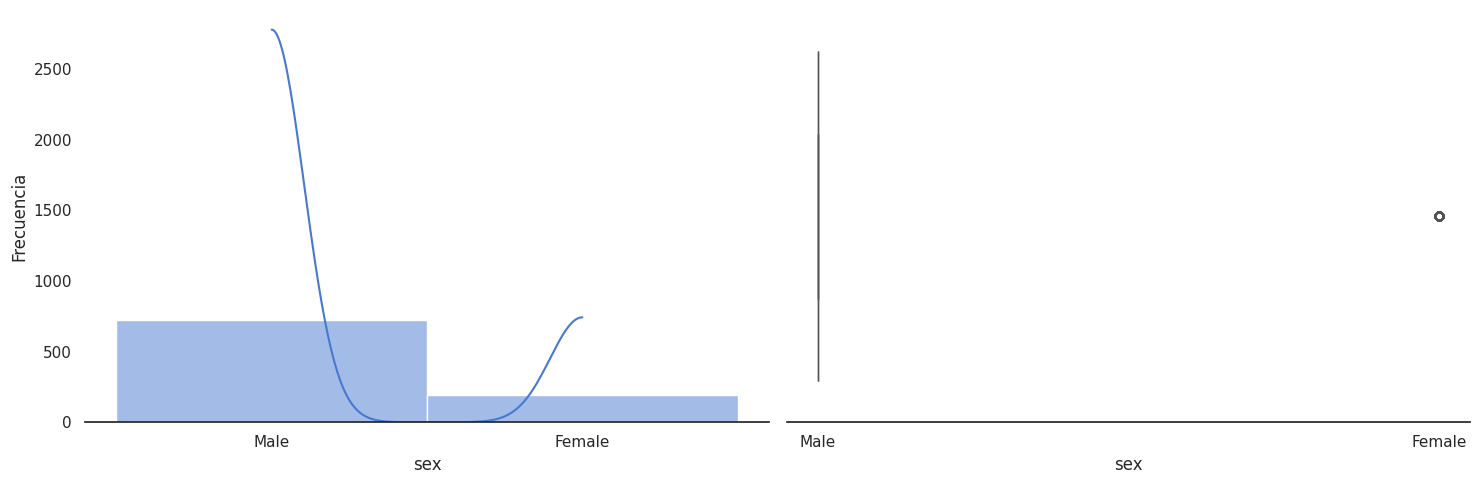

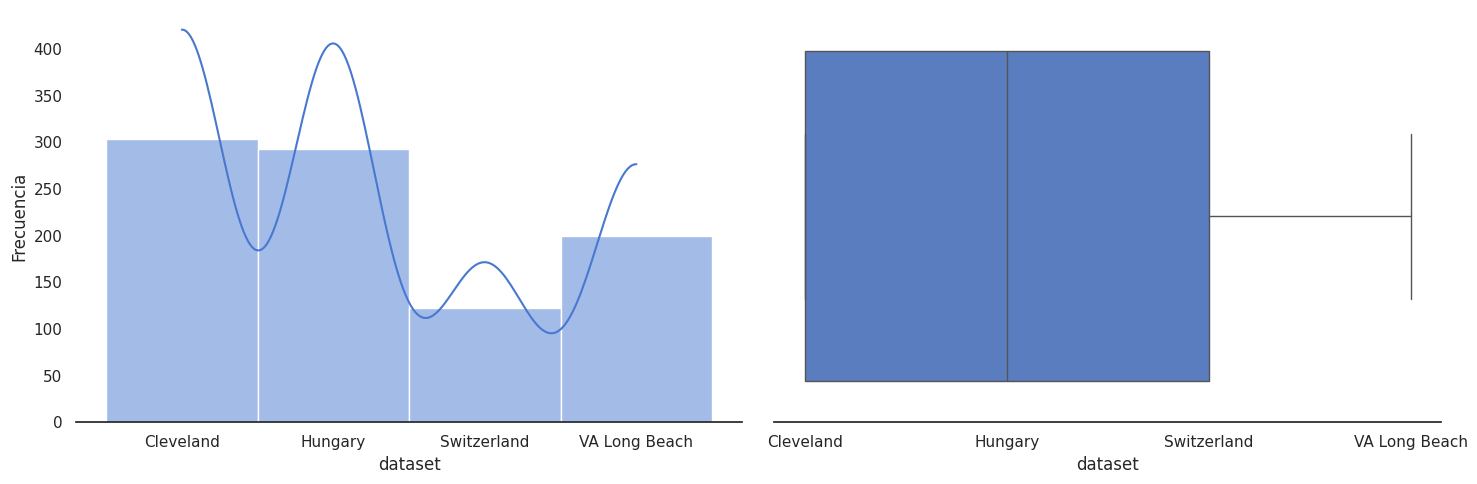

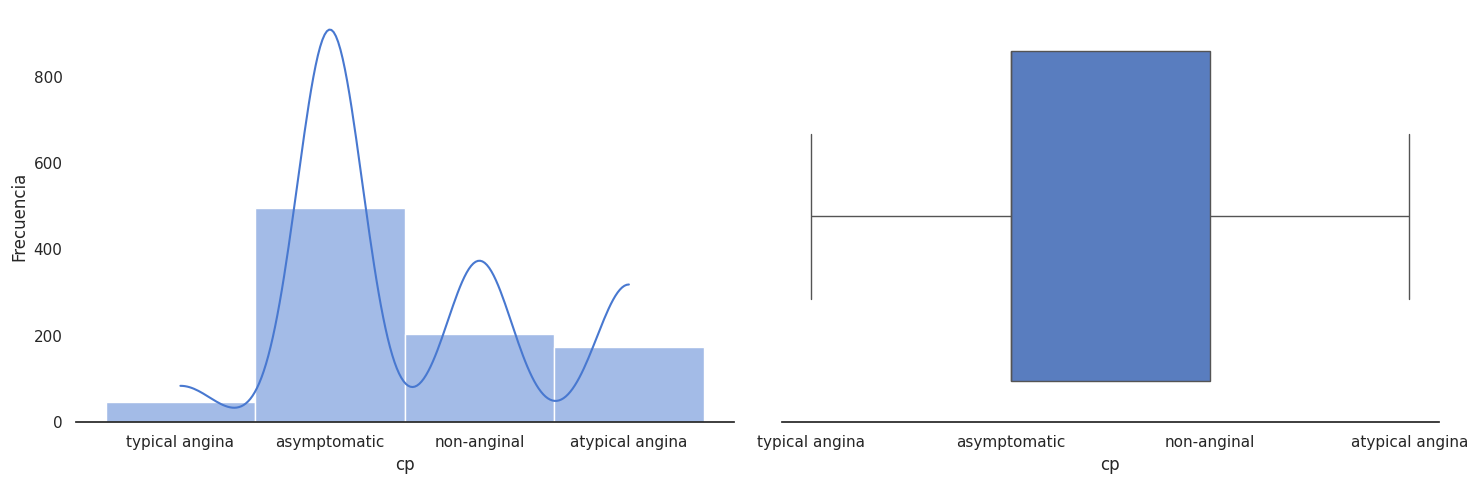

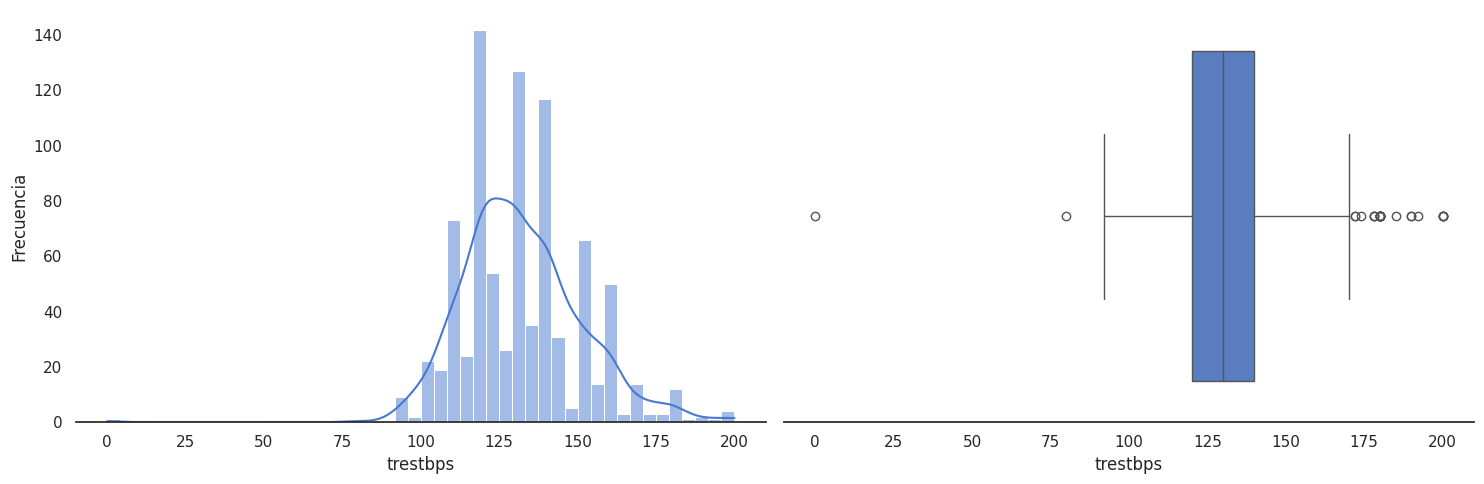

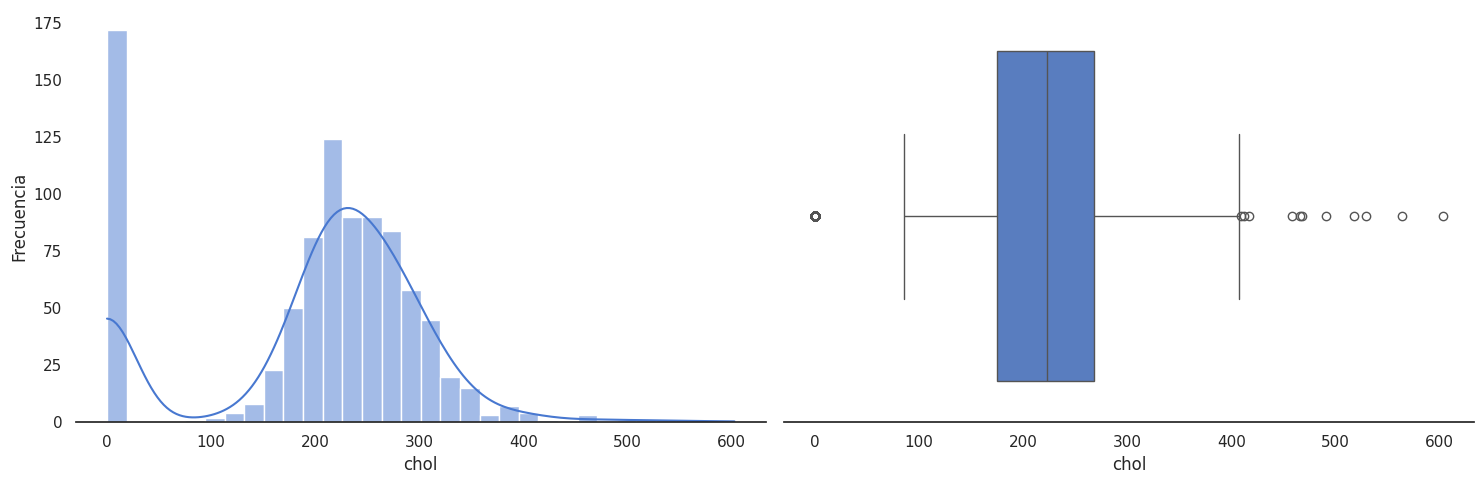

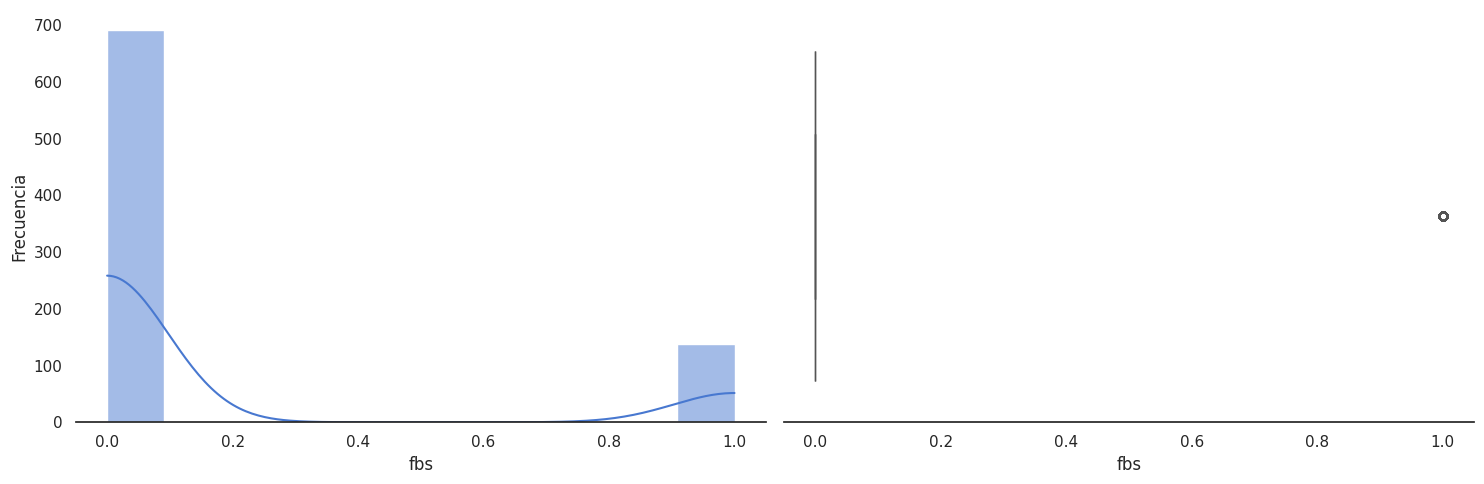

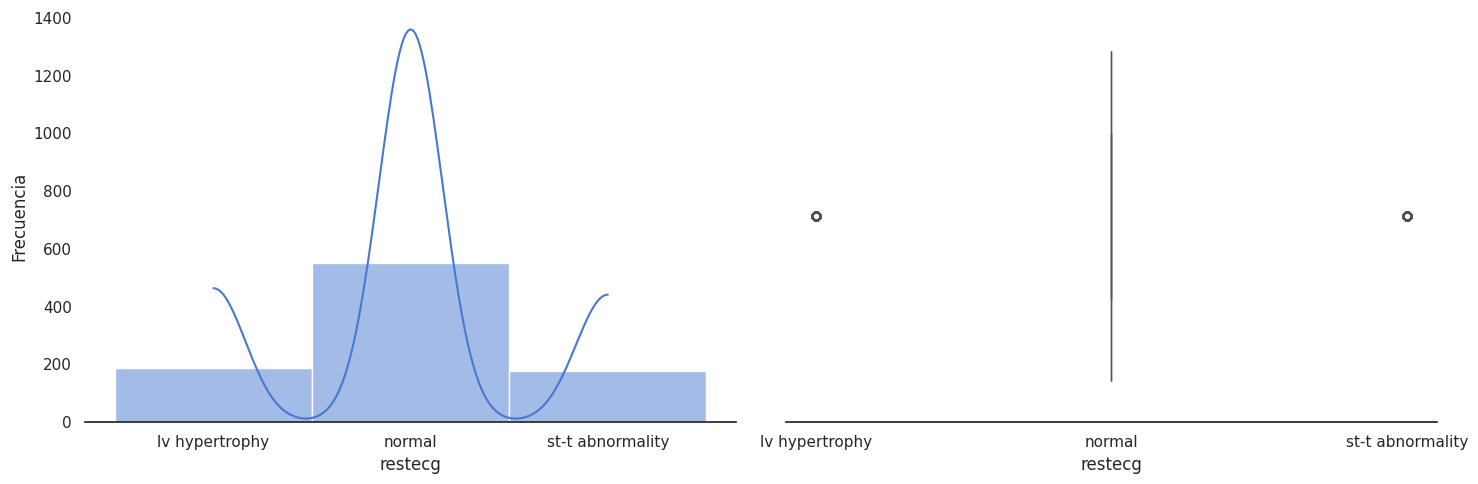

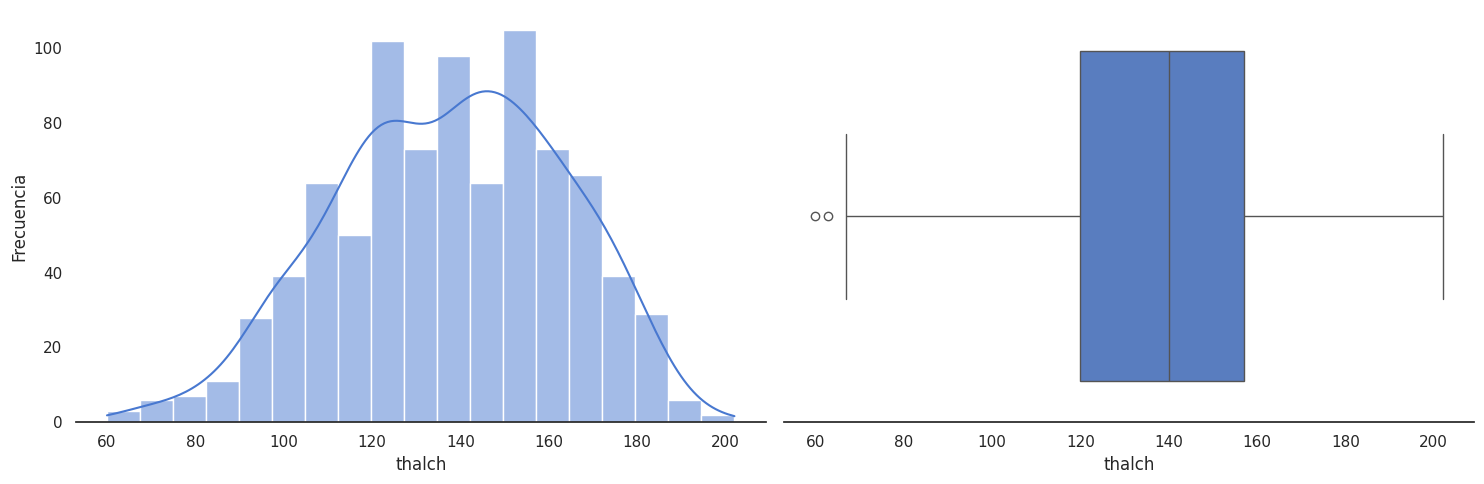

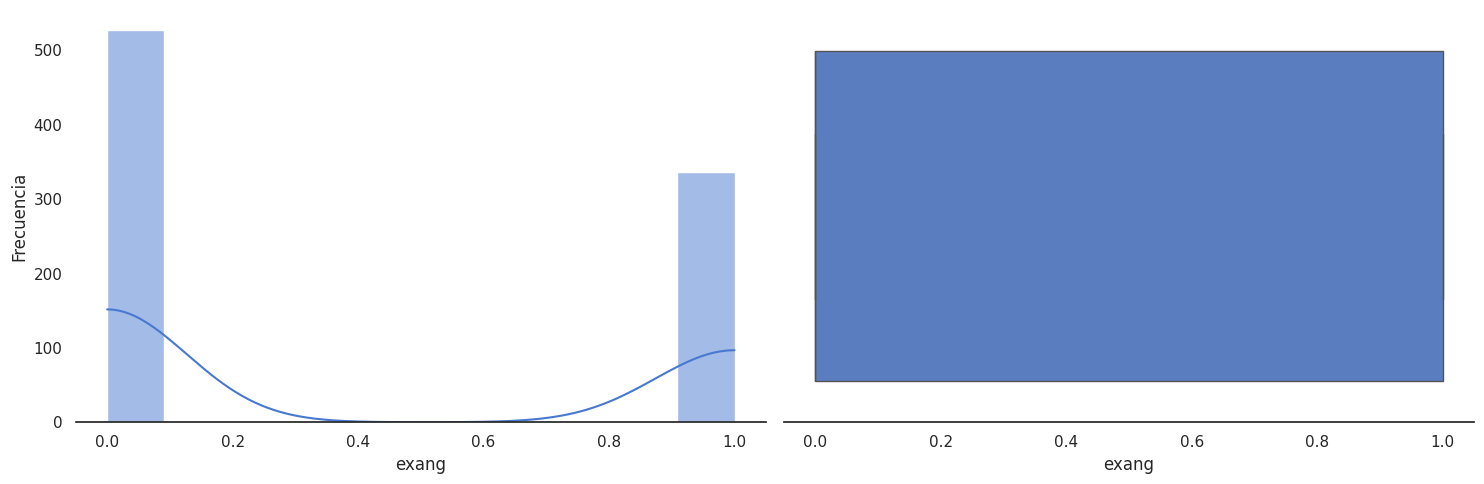

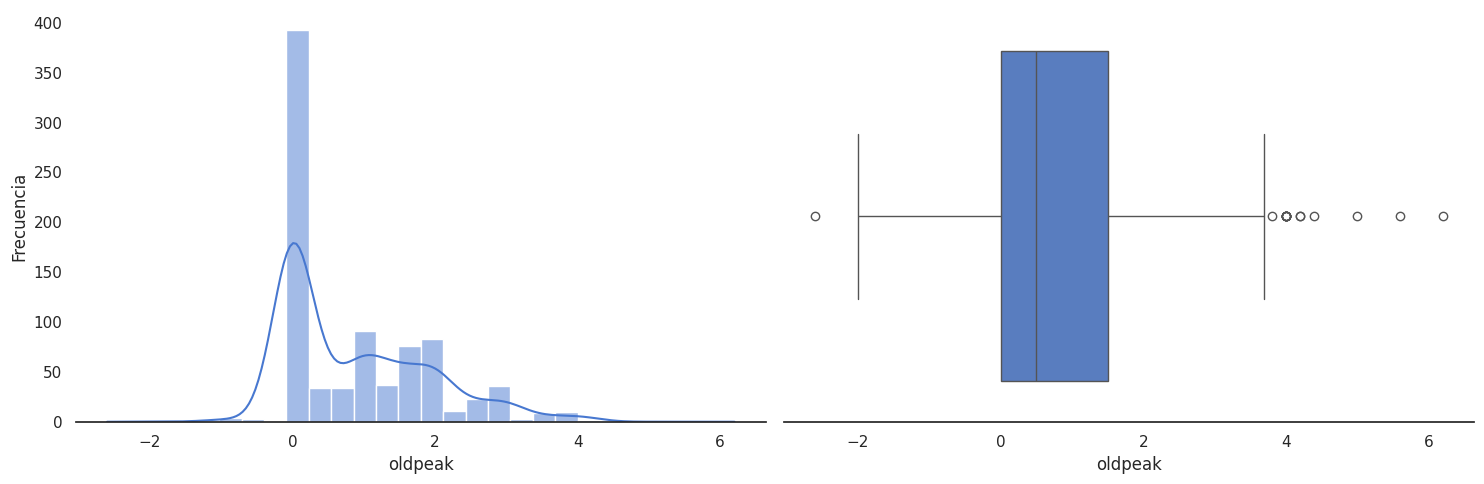

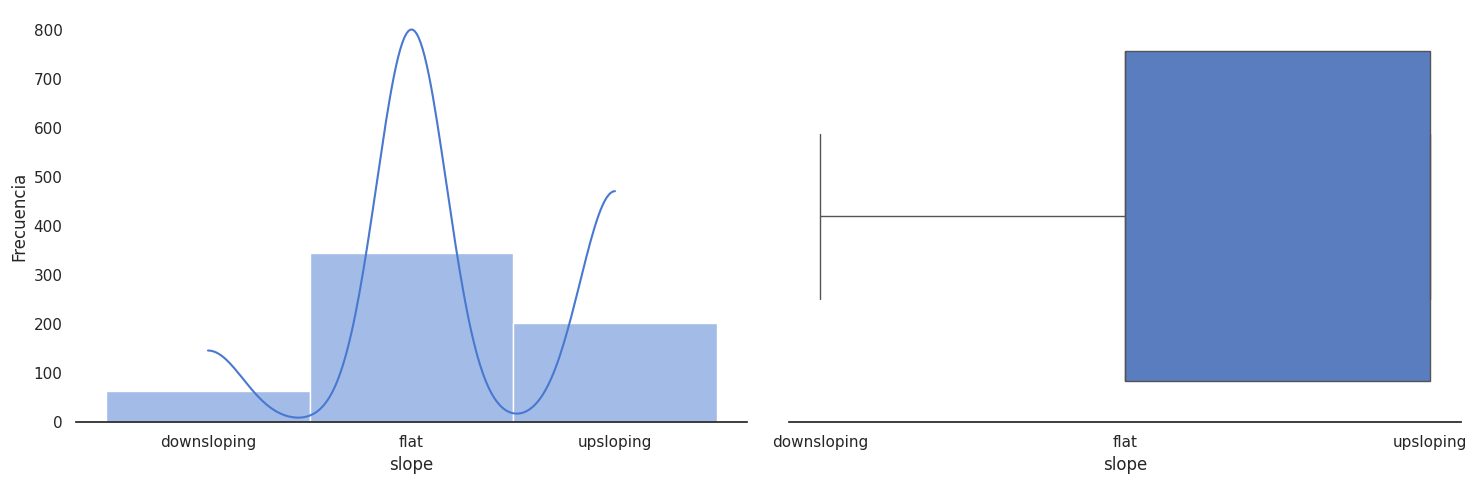

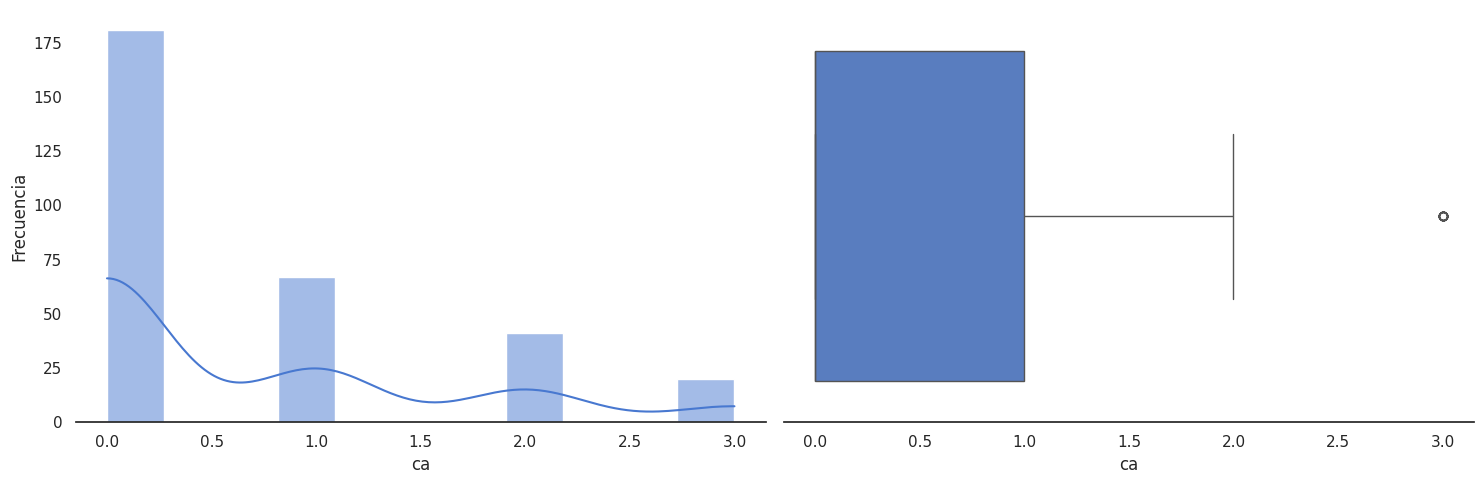

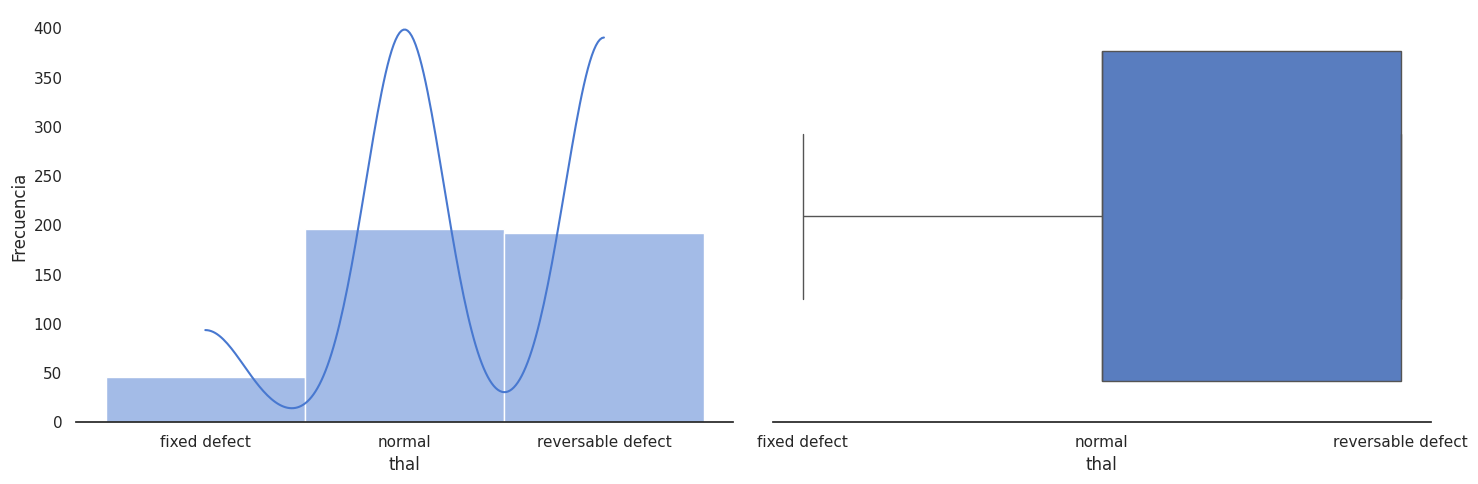

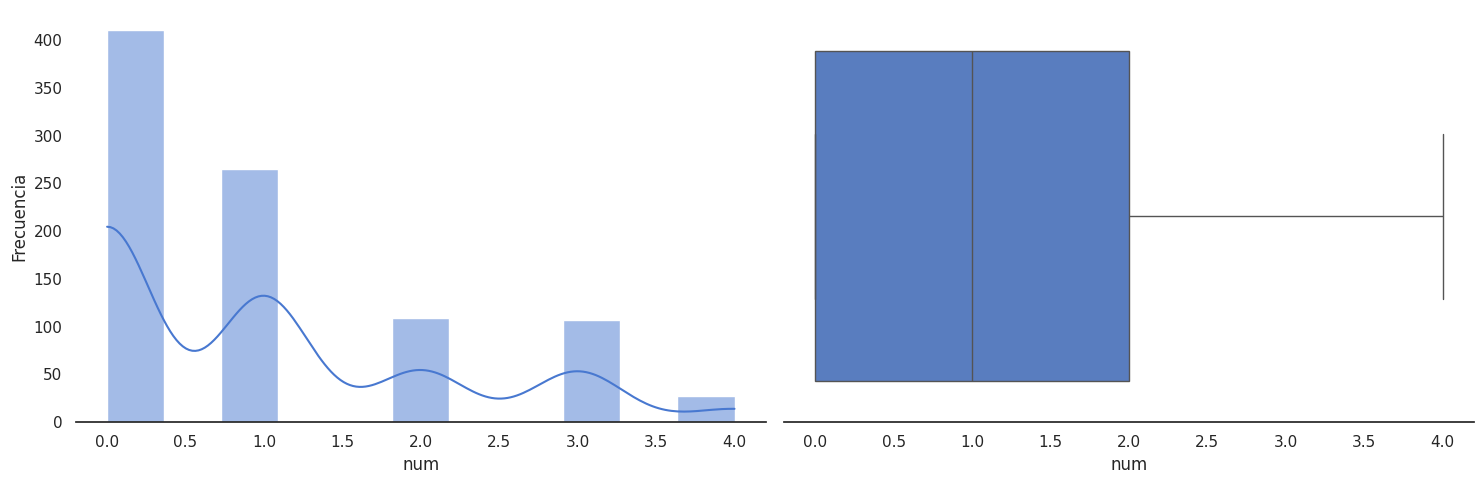

In [25]:
def vis_hist_boxplot(df):
    for i in df.columns:
        fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.despine(left=True)

        # Histograma con kde
        sns.histplot(data=df, x=i, kde=True, ax=ax[0]).set_xlabel(f"{i}")
        ax[0].set_ylabel('Frecuencia')
        # Boxplot
        sns.boxplot(data=df, x=i, ax=ax[1])

        plt.tight_layout()
        plt.show()

vis_hist_boxplot(df)

In [26]:
# Revisar valores únicos y conteo ordenado de alguna variable
var = df['chol'].value_counts().sort_index()
var

,count
chol,
0.0,172
85.0,1
100.0,2
117.0,1
126.0,1
...,...
491.0,1
518.0,1
529.0,1


In [27]:
# Aplicar filtros basados en los rangos clínicos
df_cleaned = df[
    (df['trestbps'].between(80, 200)) &
    (df['chol'].between(80, 600)) &
    (df['thalch'].between(59, 220)) &
    (df['oldpeak'].between(0, 6))
]

# Mostrar resumen después de limpieza
print(df_cleaned.describe().round())

          id    age  trestbps   chol  thalch  oldpeak     ca    num
count  670.0  670.0     670.0  670.0   670.0    670.0  301.0  670.0
mean   373.0   53.0     133.0  247.0   141.0      1.0    1.0    1.0
std    251.0    9.0      18.0   57.0    25.0      1.0    1.0    1.0
min      1.0   28.0      92.0   85.0    69.0      0.0    0.0    0.0
25%    169.0   46.0     120.0  211.0   123.0      0.0    0.0    0.0
50%    340.0   54.0     130.0  240.0   142.0      0.0    0.0    0.0
75%    523.0   59.0     140.0  276.0   160.0      2.0    1.0    1.0
max    920.0   77.0     200.0  564.0   202.0      6.0    3.0    4.0


In [28]:
df = df_cleaned.copy()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        670 non-null    int64  
 1   age       670 non-null    int64  
 2   sex       670 non-null    object 
 3   dataset   670 non-null    object 
 4   cp        670 non-null    object 
 5   trestbps  670 non-null    float64
 6   chol      670 non-null    float64
 7   fbs       660 non-null    object 
 8   restecg   669 non-null    object 
 9   thalch    670 non-null    float64
 10  exang     670 non-null    object 
 11  oldpeak   670 non-null    float64
 12  slope     464 non-null    object 
 13  ca        301 non-null    float64
 14  thal      349 non-null    object 
 15  num       670 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 89.0+ KB


In [30]:
from sklearn.preprocessing import LabelEncoder

# Crea una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Ajusta y transforma las columnas 'fbs' y 'sex'
df['fbs'] = label_encoder.fit_transform(df['fbs'])
df['sex'] = label_encoder.fit_transform(df['sex'])

In [31]:
# Crear un df solo con las variables numéricas
numeric_df = df.select_dtypes(include=np.number)
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 0 to 919
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        670 non-null    int64  
 1   age       670 non-null    int64  
 2   sex       670 non-null    int64  
 3   trestbps  670 non-null    float64
 4   chol      670 non-null    float64
 5   fbs       670 non-null    int64  
 6   thalch    670 non-null    float64
 7   oldpeak   670 non-null    float64
 8   ca        301 non-null    float64
 9   num       670 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 57.6 KB


In [32]:
numeric_df = numeric_df.drop('id', axis=1)

In [33]:
# Verificando si hay datos nulos (%)
print("Valores nulos:")
print((numeric_df.isnull().sum() * 100 / len(numeric_df)).round(2))
print("\n")

Valores nulos:
age          0.00
sex          0.00
trestbps     0.00
chol         0.00
fbs          0.00
thalch       0.00
oldpeak      0.00
ca          55.07
num          0.00
dtype: float64




In [34]:
outliers_IQR(numeric_df)


🚩 Outliers detected in age: 0

🚩 Outliers detected in sex: 0

🚩 Outliers detected in trestbps: 19

🚩 Outliers detected in chol: 21

🚩 Outliers detected in fbs: 108

🚩 Outliers detected in thalch: 0

🚩 Outliers detected in oldpeak: 14

🚩 Outliers detected in ca: 19

🚩 Outliers detected in num: 74


In [35]:
# Eliminar la columna 'ca' del DataFrame numeric_df
numeric_df = numeric_df.drop('ca', axis=1)
numeric_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 0 to 919
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       670 non-null    int64  
 1   sex       670 non-null    int64  
 2   trestbps  670 non-null    float64
 3   chol      670 non-null    float64
 4   fbs       670 non-null    int64  
 5   thalch    670 non-null    float64
 6   oldpeak   670 non-null    float64
 7   num       670 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 47.1 KB


## Análisis
- Se realizó la carga de datos y se verificó que no hubieran nulos, duplicados o outliers, se encontró que no hay duplicados, que algunas variables tiene un alto porcentaje de nulos (en este dataset) y que hay outliers en otras variables.

- Al revisarse las estadísticas descriptivas para las variables numéricas y categóricas (por separado), se encuentra que en algunas de estas categóricas que tienen nulos, es complejo la imputación cuando hay más de 2 categorías, o si se realizará la transformación como tal de si está presente el dato o no, aunque dudo de que esto tenga algún sentido biológico o médico como tal, así que se dejaron así ya que se trabajaría solo con las variables numéricas

- En cuanto a las variables numéricas, hay algunas que son “mediciones” de laboratorio o clínicas, que no es posible que den cero, así que se realizó una limpieza del dataset de estos datos errados, dejando solo aquellos que estuvieran dentro de los rangos “posibles” de algunas variables

- También se graficaron las variables para observar sus distribuciones y outlaiers, y como se va a trabajar con variables numéricas solamente, se decidió imputar solo aquellas que tuvieran dos niveles (sex y fbs) y se eliminaron unas variables que no se considerarían en los análisis posteriores.


# 2. Exploración y preprocesamiento de datos:

  – Realiza una división del dataset en conjunto de entrenamiento y prueba. Asegúrate de que el dataset esté bien balanceado, verificando la distribución de la variable objetivo (enfermedad cardíaca sí/no).

In [36]:
var1 = numeric_df['num'].value_counts().sort_index()
var1

,count
num,
0,354
1,185
2,57
3,56
4,18


In [37]:
numeric_df['num'] = (numeric_df['num'] > 0).astype(int)  # Convertimos en binario (0 = sano, 1 = enfermedad)

In [38]:
var2 = numeric_df['num'].value_counts().sort_index()
var2

,count
num,
0,354
1,316


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# Separar características y variable objetivo
X = numeric_df.drop(columns=['num'])
y = numeric_df['num']

# División en conjunto de entrenamiento y prueba (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calcular pesos de clase para el entrenamiento
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
print("Pesos de clase:", class_weights)

Pesos de clase: {0: 0.9469964664310954, 1: 1.0592885375494072}


## Análisis


- Al realizar este punto, se debió revisar los diferentes niveles de la variable objetivo (num), donde el nivel 0 es sano, y el resto son diferentes niveles de clasificación para la insuficiencia cardíaca, así que se modificó de tal forma que todo lo diferente a cero fuese igual a 1, y así se “mejoró” el desbalance de clases en la variable objetivo

- Finalmente se seleccionaron características y se dividió el subconjunto para después realizar el escalamiento de las características


# 3. Implementación de la MLP con Dropout:

  – Implementa una red MLP con dos capas ocultas utilizando Keras o cualquier biblioteca de deep learning.

  – Agrega capas de dropout después de cada capa oculta para reducir el riesgo de sobreajuste. Utiliza una tasa de dropout del 20-30%.
  
  – Implementa el early stopping para detener el entrenamiento cuando la precisión en el conjunto de validación deje de mejorar después de varias épocas (por ejemplo, paciencia de 5 épocas).

In [40]:
!pip install tensorflow  # Instalar la librería TensorFlow, que es utilizada para crear y entrenar modelos de aprendizaje profundo.

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
# Definir el modelo MLP (Perceptrón Multicapa)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [44]:
# Entrenamiento del modelo con los datos de entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4387 - loss: 0.7661 - val_accuracy: 0.7164 - val_loss: 0.6366
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6544 - loss: 0.6452 - val_accuracy: 0.7463 - val_loss: 0.5730
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7370 - loss: 0.5802 - val_accuracy: 0.7537 - val_loss: 0.5310
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7439 - loss: 0.5460 - val_accuracy: 0.7761 - val_loss: 0.5074
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7846 - loss: 0.5047 - val_accuracy: 0.7612 - val_loss: 0.4968
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7627 - loss: 0.5113 - val_accuracy: 0.7537 - val_loss: 0.4908
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7815 - loss: 0.4918 - val_accuracy: 0.7761 - val_loss: 0.4870
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7647 - loss: 0.4974 - val_accuracy: 0.7687 - val_loss

In [45]:
# Evaluación del modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida en conjunto de prueba: {test_loss}")
print(f"Precisión en conjunto de prueba: {test_accuracy * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7636 - loss: 0.4636 
Pérdida en conjunto de prueba: 0.4848635792732239
Precisión en conjunto de prueba: 76.87%


## Análisis
- Si bien se realizó lo solicitado, se puede apreciar que de 50 epocas, con el Dropout y Early Stopping se llegó solo hasta el 13 y se obtuvo una  precisión del 76,87%, pero debería revisarse otras métricas para evaluar este problema de clasificación

# 4. Entrenamiento del modelo:

  – Entrena el modelo con early stopping activado, utilizando el optimizador Adam y la función de pérdida binaria (binary_crossentropy). Entrena durante un máximo de 100 épocas.
  
  – Visualiza las curvas de aprendizaje para observar cómo evoluciona la pérdida y la precisión a lo largo del entrenamiento, especialmente con early stopping activado.

In [46]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo con early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7812 - loss: 0.4839 - val_accuracy: 0.7463 - val_loss: 0.4857
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7775 - loss: 0.4834 - val_accuracy: 0.7687 - val_loss: 0.4853
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7433 - loss: 0.4916 - val_accuracy: 0.7612 - val_loss: 0.4859
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8146 - loss: 0.4596 - val_accuracy: 0.7761 - val_loss: 0.4869
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7698 - loss: 0.4889 - val_accuracy: 0.7463 - val_loss: 0.4893
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7912 - loss: 0.4821 - val_accuracy: 0.7388 - val_loss: 0.4909
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8002 - loss: 0.4593 - val_accuracy: 0.7388 - val_loss: 0.4926


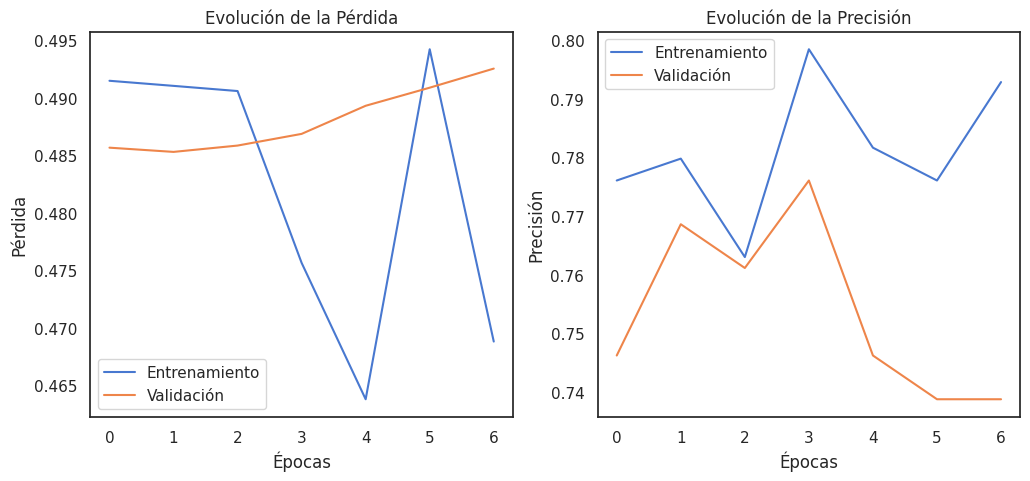

In [47]:
# Extraer datos del historial de entrenamiento
loss = history.history['loss']  # Pérdida durante el entrenamiento
val_loss = history.history['val_loss']  # Pérdida durante la validación
accuracy = history.history['accuracy']  # Precisión durante el entrenamiento
val_accuracy = history.history['val_accuracy']  # Precisión durante la validación

# Gráfico de pérdida
plt.figure(figsize=(12, 5))  # Crear una figura con tamaño especificado
plt.subplot(1, 2, 1)  # Crear una subgráfica en una fila y dos columnas (primera posición)
plt.plot(loss, label='Entrenamiento')  # Graficar la pérdida de entrenamiento
plt.plot(val_loss, label='Validación')  # Graficar la pérdida de validación
plt.title('Evolución de la Pérdida')  # Título del gráfico
plt.xlabel('Épocas')  # Etiqueta del eje X
plt.ylabel('Pérdida')  # Etiqueta del eje Y
plt.legend()  # Mostrar la leyenda

# Gráfico de precisión
plt.subplot(1, 2, 2)  # Crear una subgráfica en una fila y dos columnas (segunda posición)
plt.plot(accuracy, label='Entrenamiento')  # Graficar la precisión de entrenamiento
plt.plot(val_accuracy, label='Validación')  # Graficar la precisión de validación
plt.title('Evolución de la Precisión')  # Título del gráfico
plt.xlabel('Épocas')  # Etiqueta del eje X
plt.ylabel('Precisión')  # Etiqueta del eje Y
plt.legend()  # Mostrar la leyenda

plt.show()  # Mostrar los gráficos

## Análisis

- Conforme a las gráficas obtenidas, pareciera que hay sobreajuste, ya que en la gráfica de pérdida en algunas épocas aumenta pero en otras disminuye con la línea de entrenamiento, mientras que la de línea de validación aumenta constantemente. Otro indicio de este sobreajuste se debe a que en la gráfica de precisión, en el entrenamiento la línea sube y baja, lo que sugiere inestabilidad en el aprendizaje, y la de validación empieza bien pero después empieza a caer bastante

- Al estar el modelo sobreajustado, este puede tener buen desempeño en el entrenamiento pero mal desarrollo en la validación




# 5. Evaluación del modelo:

  – Evalúa el modelo en el conjunto de prueba y compara las métricas de rendimiento, como precisión, recall, F1-score y matriz de confusión.
  
  – Discute cómo el uso de dropout y early stopping ha afectado el rendimiento en comparación con un MLP básico sin estas técnicas.

In [48]:
from sklearn.metrics import classification_report, confusion_matrix  # Importar las funciones para evaluar el modelo

# Predicciones en el conjunto de prueba
y_pred_probs = model.predict(X_test)  # Obtener las probabilidades de predicción para cada clase
y_pred = (y_pred_probs >= 0.5).astype(int)  # Convertir las probabilidades en predicciones binarias (umbral de 0.5)

# Informe de métricas
print("Informe de Clasificación:")  # Imprimir el título del informe
print(classification_report(y_test, y_pred, target_names=['Sin enfermedad', 'Con enfermedad']))  # Imprimir el informe de clasificación con precisión, recall y f1-score

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)  # Calcular la matriz de confusión
print("Matriz de Confusión:")  # Imprimir el título de la matriz de confusión
print(conf_matrix)  # Imprimir la matriz de confusión

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Informe de Clasificación:
                precision    recall  f1-score   support

Sin enfermedad       0.77      0.80      0.79        71
Con enfermedad       0.77      0.73      0.75        63

      accuracy                           0.77       134
     macro avg       0.77      0.77      0.77       134
  weighted avg       0.77      0.77      0.77       134

Matriz de Confusión:
[[57 14]
 [17 46]]


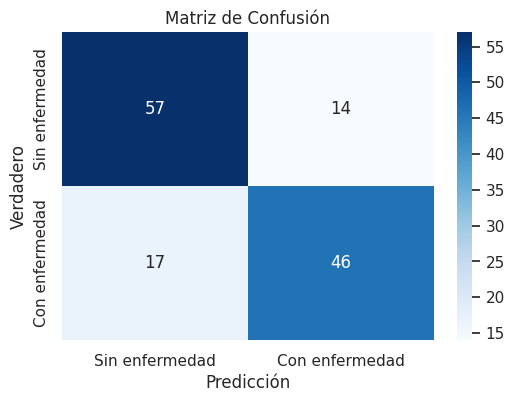

In [51]:
plt.figure(figsize=(6, 4))  # Crear una figura de tamaño especificado
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',  # Crear el gráfico de calor de la matriz de confusión
            xticklabels=['Sin enfermedad', 'Con enfermedad'],  # Etiquetas del eje X (predicciones)
            yticklabels=['Sin enfermedad', 'Con enfermedad'])  # Etiquetas del eje Y (valores verdaderos)

plt.title('Matriz de Confusión')  # Título del gráfico
plt.xlabel('Predicción')  # Etiqueta del eje X
plt.ylabel('Verdadero')  # Etiqueta del eje Y
plt.show()  # Mostrar el gráfico


## Análisis

- El modelo con esta evaluación tiene una tendencia a cometer errores considerables en los falsos positivos y los falsos negativos.

- Si bien la Precision del 77% sugiere que hay un equilibrio razonable en la asignación a las clases, y además con un F1-Score del mismo valor, se sugiere un buen rendimiento

- Se debe revisar si se puede optimizar el modelo dado que, con la Accuracy del 77% se estaría sugiriendo que 3 de cada 4 predicciones son correctas, lo cual es "delicado" en términos del estudio. Ya que si bien la variable objetivo está codificada como Sin o Con enfermedad, biológicamente el nivel "Con enfermedad" tiene 4 posibles valores en términos médicos, por lo que, incluso el fallar en predecir que tenga o no la enfermedad, puede ser muy delicado sabiendo que si la persona tiene le enfermedad y no se clasifica como tal, y esta persona tiene un grado o clase 3 o 4 de este tipo de enfermedaes, es delicado decir o pronosticarlo como no enfermo cuando puede estar en situaciones críticas

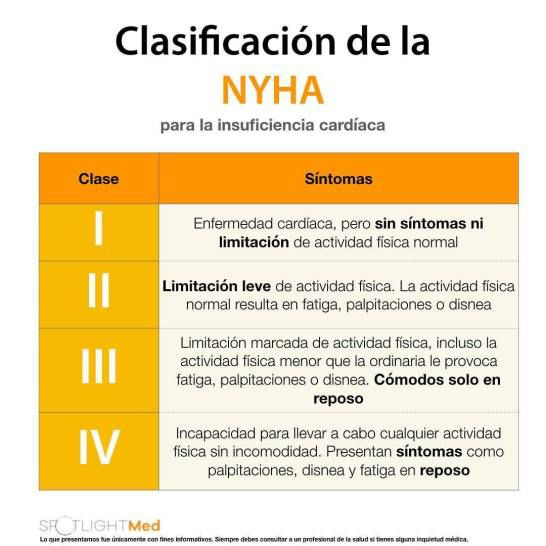

## Finalmente

Me dio por curiosiar dado que el código no estaba complejo, y cambié algo para revisar como se comportaba el neuvo modelo

In [52]:
# Modelo MLP con Dropout
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Regularización para evitar sobreajuste
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Salida binaria (0 o 1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping para detener el entrenamiento si la validación empeora
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # 20% del entrenamiento se usará para validación
    epochs=100,
    batch_size=16,  # Tamaño de batch más pequeño para mejorar estabilidad
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4552 - loss: 0.7390 - val_accuracy: 0.7315 - val_loss: 0.6450
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5968 - loss: 0.6634 - val_accuracy: 0.8056 - val_loss: 0.5753
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6749 - loss: 0.6213 - val_accuracy: 0.7963 - val_loss: 0.5221
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7237 - loss: 0.5724 - val_accuracy: 0.7870 - val_loss: 0.4910
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7290 - loss: 0.5703 - val_accuracy: 0.7870 - val_loss: 0.4623
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7617 - loss: 0.5423 - val_accuracy: 0.8056 - val_loss: 0.4478
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7893 - loss: 0.5416 - val_accuracy: 0.7870 - val_loss: 0.4486
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7304 - loss: 0.5354 - val_accuracy: 0.7870 - 

In [54]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida en conjunto de prueba: {loss:.4f}')
print(f'Precisión en conjunto de prueba: {accuracy * 100:.2f}%')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7607 - loss: 0.4542
Pérdida en conjunto de prueba: 0.4785
Precisión en conjunto de prueba: 76.12%


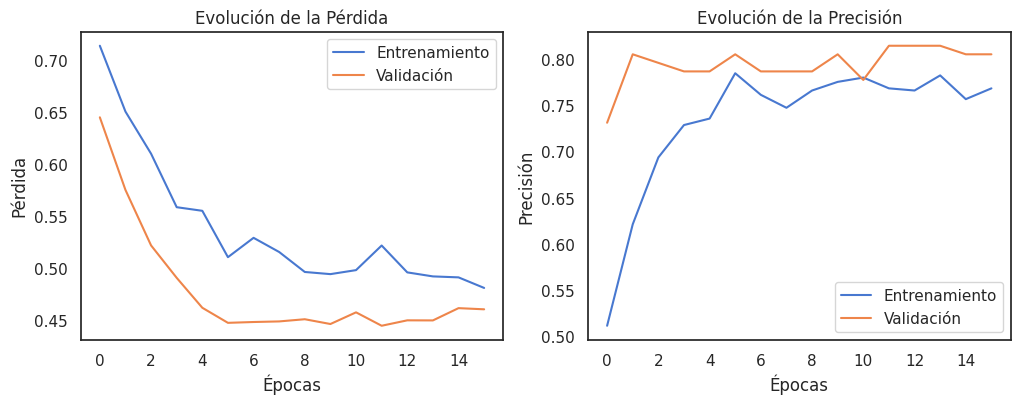

In [55]:
import matplotlib.pyplot as plt

# Pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la Precisión')
plt.legend()

plt.show()


In [56]:
# Predicciones en el conjunto de prueba
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Informe de métricas
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Sin enfermedad', 'Con enfermedad']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Informe de Clasificación:
                precision    recall  f1-score   support

Sin enfermedad       0.74      0.85      0.79        71
Con enfermedad       0.79      0.67      0.72        63

      accuracy                           0.76       134
     macro avg       0.77      0.76      0.76       134
  weighted avg       0.77      0.76      0.76       134

Matriz de Confusión:
[[60 11]
 [21 42]]


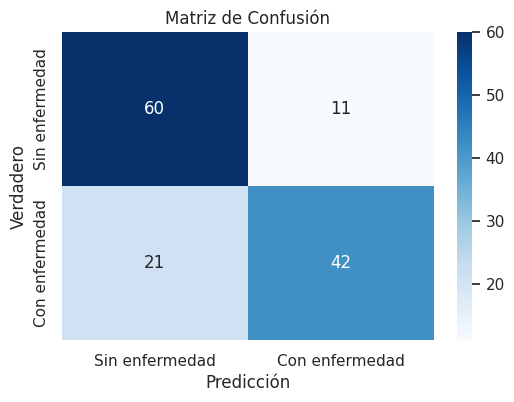

In [57]:
plt.figure(figsize=(6, 4))  # Crear una figura de tamaño especificado
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',  # Crear el gráfico de calor de la matriz de confusión
            xticklabels=['Sin enfermedad', 'Con enfermedad'],  # Etiquetas del eje X (predicciones)
            yticklabels=['Sin enfermedad', 'Con enfermedad'])  # Etiquetas del eje Y (valores verdaderos)

plt.title('Matriz de Confusión')  # Título del gráfico
plt.xlabel('Predicción')  # Etiqueta del eje X
plt.ylabel('Verdadero')  # Etiqueta del eje Y
plt.show()  # Mostrar el gráfico

## Análisis

Comparación con la anterior:

- Se redujeron los falsos negativos (FN) de 14 → 11 (mejor detección de enfermos). Pero aumentaron los falsos positivos (FP) de 17 → 21 (más personas sanas clasificadas erróneamente como enfermas).

- También hay más aciertos en "Sin enfermedad" (de 57 a 60), pero menos en "Con enfermedad" (de 46 a 42).

En general hay mejoras como:
- Detección de más personas sanas correctamente (mayor recall en "Sin enfermedad").
- Reducción de los falsos negativos (menos enfermos no detectados).
- Mejor precisión en la clase "Con enfermedad", lo que significa menos falsos positivos.

Y puntos a mejorar:
- Mayor número de falsos positivos (más personas sanas mal diagnosticadas).
- Menor recall en "Con enfermedad" (se están escapando más enfermos que antes).